# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)
- 24/11/2023:
    - Included loading of document loader cache options (DLCOs)
- 26/11/2023
    - Histogram plots per DLCO group, for `deriveIdentityCredential`, `deriveDiplomaCredential`, `verifyPresentation01`, and `verifyPresentation02`

---

Todos:

- integrate host reports (since profiler-v2)


In [1]:
import os
import json
import git
import re
import numpy as np
np.random.seed(42)
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-12-06T11:42:51'

Plot config

In [2]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [3]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


def read_json(fpath: str) -> dict:
    return json.loads(open(fpath, 'r').read())

def parse_js_timestamp(jsts: int):
    """Parse timestamps created using JS/TS's `Date.now()`.
    Ref: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now
    """
    return datetime.datetime.utcfromtimestamp(jsts/1000)


## Input data

WIP: incorporating multi-actor profiling reports with varying document loader option configurations.

Note: timestamps were created using JS/TS's `Date.now()`.

> The Date.now() static method returns the number of milliseconds elapsed since the epoch, which is defined as the midnight at the beginning of January 1, 1970, UTC.

<https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now>

In [4]:
def create_report_df(s_json_report_files: pd.Series) -> pd.DataFrame:
    """v20231125 - expects pd.Series containing the paths to the multi-actor report (JSON).
    These reports are expected to also include other metadata (e.g. document loader cache option configuration)
    Returns pd.DataFrame from parsed records
    """
    # Split filpaths into a parentdir & the basename of the json file
    df_files = s_json_report_files.apply(os.path.split).apply(pd.Series)
    df_files.columns = ['parent_dir','basename']
    df_files['fpath'] = s_json_report_files
    # Parse the timestamps (cfr. Date.now() in JS/TS)
    df_files['parent_dir_ts'] = df_files.parent_dir.apply(os.path.basename).astype(int).apply(parse_js_timestamp)
    df_files['report_ts'] = df_files.basename.str.replace('.json','').apply(lambda x: x.split('-')[-1]).astype(int).apply(parse_js_timestamp)

    # Read JSON files into a dataframe
    _df = df_files.iloc[:].fpath.apply(read_json).apply(pd.Series)
    # Process Document Loader Cache Options
    _df_dlco = _df['documentLoaderCacheOptions'].apply(pd.Series).stack().apply(pd.Series).unstack(1).swaplevel(axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    _df_dlco.index.set_names('idx_report',inplace=True)
    # Flatten columns
    _df_dlco.columns = list(map(lambda t: '_'.join(t), _df_dlco.columns))

    # Process multi actor records
    _df_records = _df.records.apply(pd.Series).stack()
    _df_records.index.set_names(['idx_report','idx_step'],inplace=True)
    _df_records = _df_records.apply(pd.Series).drop('index',axis=1)
    
    # Combine
    _df_result = pd.concat({'report': _df_records,}, axis=1).merge(pd.concat({'dlco':_df_dlco}, axis=1), left_index=True, right_index=True)
    assert _df_result.shape[0] == _df_records.shape[0] # sanity check
    
    # Column renaming
    _df_result.rename({'tag': 'actorTag', 'name': 'stepName', },axis=1,inplace=True)
    _df_result[('report','actorStep')] = _df_result.apply(lambda r: f'{r.report.actorTag}.{r.report.stepName}',axis=1)
    _df_result.sort_index(axis=1,inplace=True)
    return _df_result
    

## Analysis

In [5]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

In [6]:
def create_solution_label_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Sanity check: in every report, there must be exactly one className per actorTag (otherwise, smth went wrong)
    assert (df.report.reset_index().groupby(['idx_report','actorTag'])['className'].unique().apply(len) == 1).all()    
    # Create a dataframe that labels which solution the report represents (the solution label depends on which kind of implementation was used for actor Alice)
    df_report_solution_label = df.report.reset_index().groupby(['idx_report','actorTag'])['className'].unique().apply(lambda x: x[0]).unstack('actorTag')
    def extract_solution_label(r):
        assert r.alice.startswith('CompoundCredentialActor') # sanity check
        # The first and second classnames are used for the public and pseudonymous identity, respectively.
        [public_identity_classname, pseudo_identity_classname] = r.alice.replace('CompoundCredentialActor<','').replace('>','').split(',')

        lbl = None
        if pseudo_identity_classname == 'SolidVCActor':
            lbl = 'third-party'
        elif pseudo_identity_classname == 'DidVCActor':
            lbl = 'did-key'
        else:
            raise Exception(f'Cannot create solution label for {pseudo_identity_classname}')
        return lbl
    df_report_solution_label['solution_label'] = df_report_solution_label.apply(extract_solution_label, axis=1)
    return df_report_solution_label

def get_df() -> pd.DataFrame:

    df = create_report_df(pd.Series(glob('./reports/profiling/*/*.json')))
    n0 = df.shape[0]
    df_report_solution_label = create_solution_label_dataframe(df)
    df = df.reset_index().set_index(['idx_report']).merge(pd.concat({'report':df_report_solution_label[['solution_label']]},axis=1),left_index=True, right_index=True)
    n1 = df.shape[0]
    assert n0 == n1
    return df
df = get_df()
df.shape

(7200, 12)

In [7]:
df.report.solution_label.reset_index().groupby('idx_report').first().solution_label.value_counts()

solution_label
third-party    300
did-key        300
Name: count, dtype: int64

The reports will be considered in groups, divided by the following group columns:
    
- `actorTag`: the name/tag of an actor within the context of the use case (e.g. alice)
- `className`: the classname of an actor's implementation (e.g. `SolidVCACtor`)
- `actorStep` the profiled step/action taken by the actor (e.g. `verifyPresentation`)

In [8]:
def equalize_groupsizes(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    """ Creates equally sized groups (based on the smallest group size).
    """
    grpr = df.groupby(group_columns)
    n_smallest_group = grpr.size().min()
    idx_to_drop = []
    for i,g_idx in grpr.groups.items():
        ni_idx_to_drop = g_idx.size - n_smallest_group
        np.random.seed(42)
        idx_to_drop.append(np.random.choice(g_idx,size=ni_idx_to_drop))

    idx_to_drop = np.concatenate(idx_to_drop)
    return df.drop(index=idx_to_drop)

In [9]:
def jsonpath2multi_index_tuple(path: str):
    """
    Example: 
    jsonpath2multi_index_tuple('report.actorTag')
    ('report', 'actorTag')
    """
    return tuple(path.split('.'))

In [10]:
jsonpath2multi_index_tuple('report.actorTag')

('report', 'actorTag')

In [11]:
# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)
# Create multi-index (for later)
df_phase_steps = pd.concat({'report':df_phase_steps},axis=1)
# sanity check: make sure that actorSteps exactly match
x = set(df.report.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.report.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df.reset_index().merge(df_phase_steps, on=[('report','actorStep')])

# Log(1+delta) transform to get a "more Gaussian" distribution
df_tl[('report','delta_log1p')] = df_tl[('report','delta')].apply(np.log1p)

# Equalize group sizes
GROUP_COLUMNS = list(map(jsonpath2multi_index_tuple, ['report.actorTag','report.className','report.actorStep']))
df_tl = equalize_groupsizes(df_tl, GROUP_COLUMNS)

df_tl

idx_report idx_step                     dlco  \
                         DID_cacheResolvedDIDDocs   
0             0        0                    False   
2             2        0                    False   
3             3        0                    False   
5             5        0                    False   
6             6        0                    False   
...         ...      ...                      ...   
7195        595       11                    False   
7196        596       11                    False   
7197        597       11                    False   
7198        598       11                    False   
7199        599       11                    False   

                                                           \
     HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
0                                                 False     
2                                                 False     
3                                                 False     
5                                                 False     
6                                                 False     
...                                                 ...     
7195                                              False     
7196                                              False     
7197                                              False     
7198                                              False     
7199                                              False     

                                               \
     HTTP_cacheWebResourcesResolvedFromTheWeb   
0                                       False   
2                                       False   
3                                       False   
5                                       False   
6                                       False   
...                                       ...   
7195                                    False   
7196                                    False   
7197                                    False   
7198                                    False   
7199                                    False   

                                  report                                  \
                               actorStep    actorTag     className delta   
0     university.createDiplomaCredential  university  SolidVCActor     0   
2     university.createDiplomaCredential  university  SolidVCActor     0   
3     university.createDiplomaCredential  university  SolidVCActor     0   
5     university.createDiplomaCredential  university  SolidVCActor     0   
6     university.createDiplomaCredential  university  SolidVCActor     0   
...                                  ...         ...           ...   ...   
7195      recruiter.verifyPresentation02   recruiter  SolidVCActor   265   
7196      recruiter.verifyPresentation02   recruiter  SolidVCActor   222   
7197      recruiter.verifyPresentation02   recruiter  SolidVCActor   235   
7198      recruiter.verifyPresentation02   recruiter  SolidVCActor   303   
7199      recruiter.verifyPresentation02   recruiter  SolidVCActor   248   

                                                                            \
                end          start                 stepName solution_label   
0     1701850242065  1701850242065  createDiplomaCredential    third-party   
2     1701852220501  1701852220501  createDiplomaCredential    third-party   
3     1701851846655  1701851846655  createDiplomaCredential    third-party   
5     1701852300810  1701852300810  createDiplomaCredential    third-party   
6     1701851883827  1701851883827  createDiplomaCredential    third-party   
...             ...            ...                      ...            ...   
7195  1701854441950  1701854441685     verifyPresentation02        did-key   
7196  1701854898696  1701854898474     verifyPresentation02        did-key   
7197  1701854906877  1701854906642     verifyPresentation02        did-key   
7198  1701855217738  1701855217435  

#### Nr. reports

In [12]:
# nr reports
N = df_tl.idx_report.unique().__len__()
N

600

#### Sample groups

In [13]:
# grouper object for the reports
grpr = df_tl.groupby(GROUP_COLUMNS)
grpr

In [14]:
GROUPS = list(grpr.groups.keys())

##### Group sizes

In [15]:
grpr.size()

(report, actorTag)  (report, className)                                 (report, actorStep)                
alice               CompoundCredentialActor<SolidVCActor,DidVCActor>    alice.createPresentation01             300
                                                                        alice.createPresentation02             300
                                                                        alice.deriveDiplomaCredential          300
                                                                        alice.deriveIdentityCredential         300
                                                                        alice.signPresentation01               300
                                                                        alice.signPresentation02               300
                    CompoundCredentialActor<SolidVCActor,SolidVCActor>  alice.createPresentation01             300
                                                                        alice.createPre

In [16]:
# sanity check: assert that the same number of samples, for each group!
if not grpr.size().value_counts().shape[0] != 0:
    raise Warning('Groups do not have an equal number of samples!')

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

‼️⚠️ (±Breaking) change(s) since profiler-v2.sh:
- We can no longer expect every report to have the same number of actor steps????? really?

In [17]:
df_tl.set_index(['idx_report','idx_step']).sort_index()

dlco  \
                    DID_cacheResolvedDIDDocs   
idx_report idx_step                            
0          0                           False   
           1                           False   
           2                           False   
           3                           False   
           4                           False   
...                                      ...   
599        7                           False   
           8                           False   
           9                           False   
           10                          False   
           11                          False   

                                                                          \
                    HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
idx_report idx_step                                                        
0          0                                                     False     
           1                                                     False     
           2                                                     False     
           3                                                     False     
           4                                                     False     
...                                                                ...     
599        7                                                     False     
           8                                                     False     
           9                                                     False     
           10                                                    False     
           11                                                    False     

                                                              \
                    HTTP_cacheWebResourcesResolvedFromTheWeb   
idx_report idx_step                                            
0          0                                           False   
           1                                           False   
           2                                           False   
           3                                           False   
           4                                           False   
...                                                      ...   
599        7                                           False   
           8                                           False   
           9                                           False   
           10                                          False   
           11                                          False   

                                                  report              \
                                               actorStep    actorTag   
idx_report idx_step                                                    
0          0          university.createDiplomaCredential  university   
           1            university.signDiplomaCredential  university   
           2         government.createIdentityCredential  government   
           3           government.signIdentityCredential  government   
           4               alice.deriveDiplomaCredential       alice   
...                                                  ...         ...   
599        7              recruiter.verifyPresentation01   recruiter   
           8              alice.deriveIdentityCredential       alice   
           9                  alice.createPresentation02       alice   
           10                   alice.signPresentation02       alice   
           11             recruiter.verifyPresentation02   recruiter   

                                                                              \
                                                             className delta   
idx_report idx_step                                                            
0          0                                              SolidVCActor     0   
           1                                              SolidVCActor  1344


df_tl[df_tl.report.className.str.startswith('Compound')].groupby('idx_report').count()

In [18]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.set_index(['idx_report','idx_step']).report.reset_index().reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
379,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
758,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
1137,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
1516,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
2116,5,createPresentation01,alice,alice.createPresentation01,phase-1
2716,6,signPresentation01,alice,alice.signPresentation01,phase-1
3316,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
3695,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
4295,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [19]:
VAR_X = 'delta_log1p'
VAR_X = 'delta'

In [20]:
kwargs_violinplot = dict(
    x=VAR_X,
    y='actorStep',
    hue='solution_label'
)

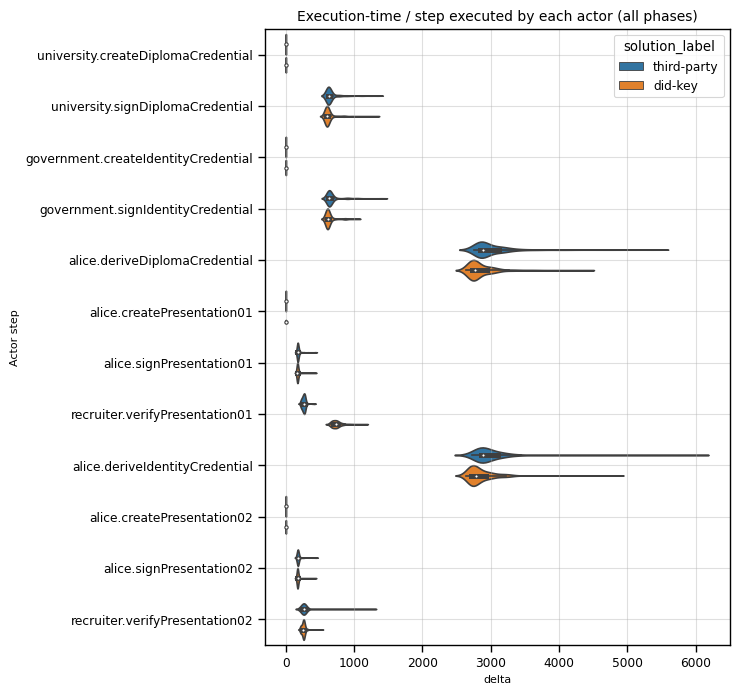

In [21]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (all phases)'
ax = sns.violinplot(df_tl.report,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(f'{kwargs_violinplot["x"]}')
ax.grid(alpha=.4)

plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

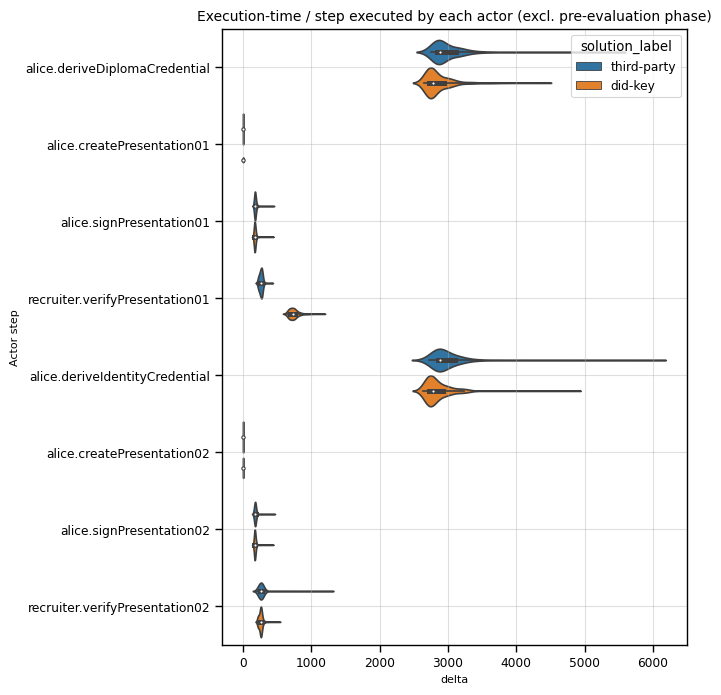

In [22]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(VAR_X)
ax.grid(alpha=.4)
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [23]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']

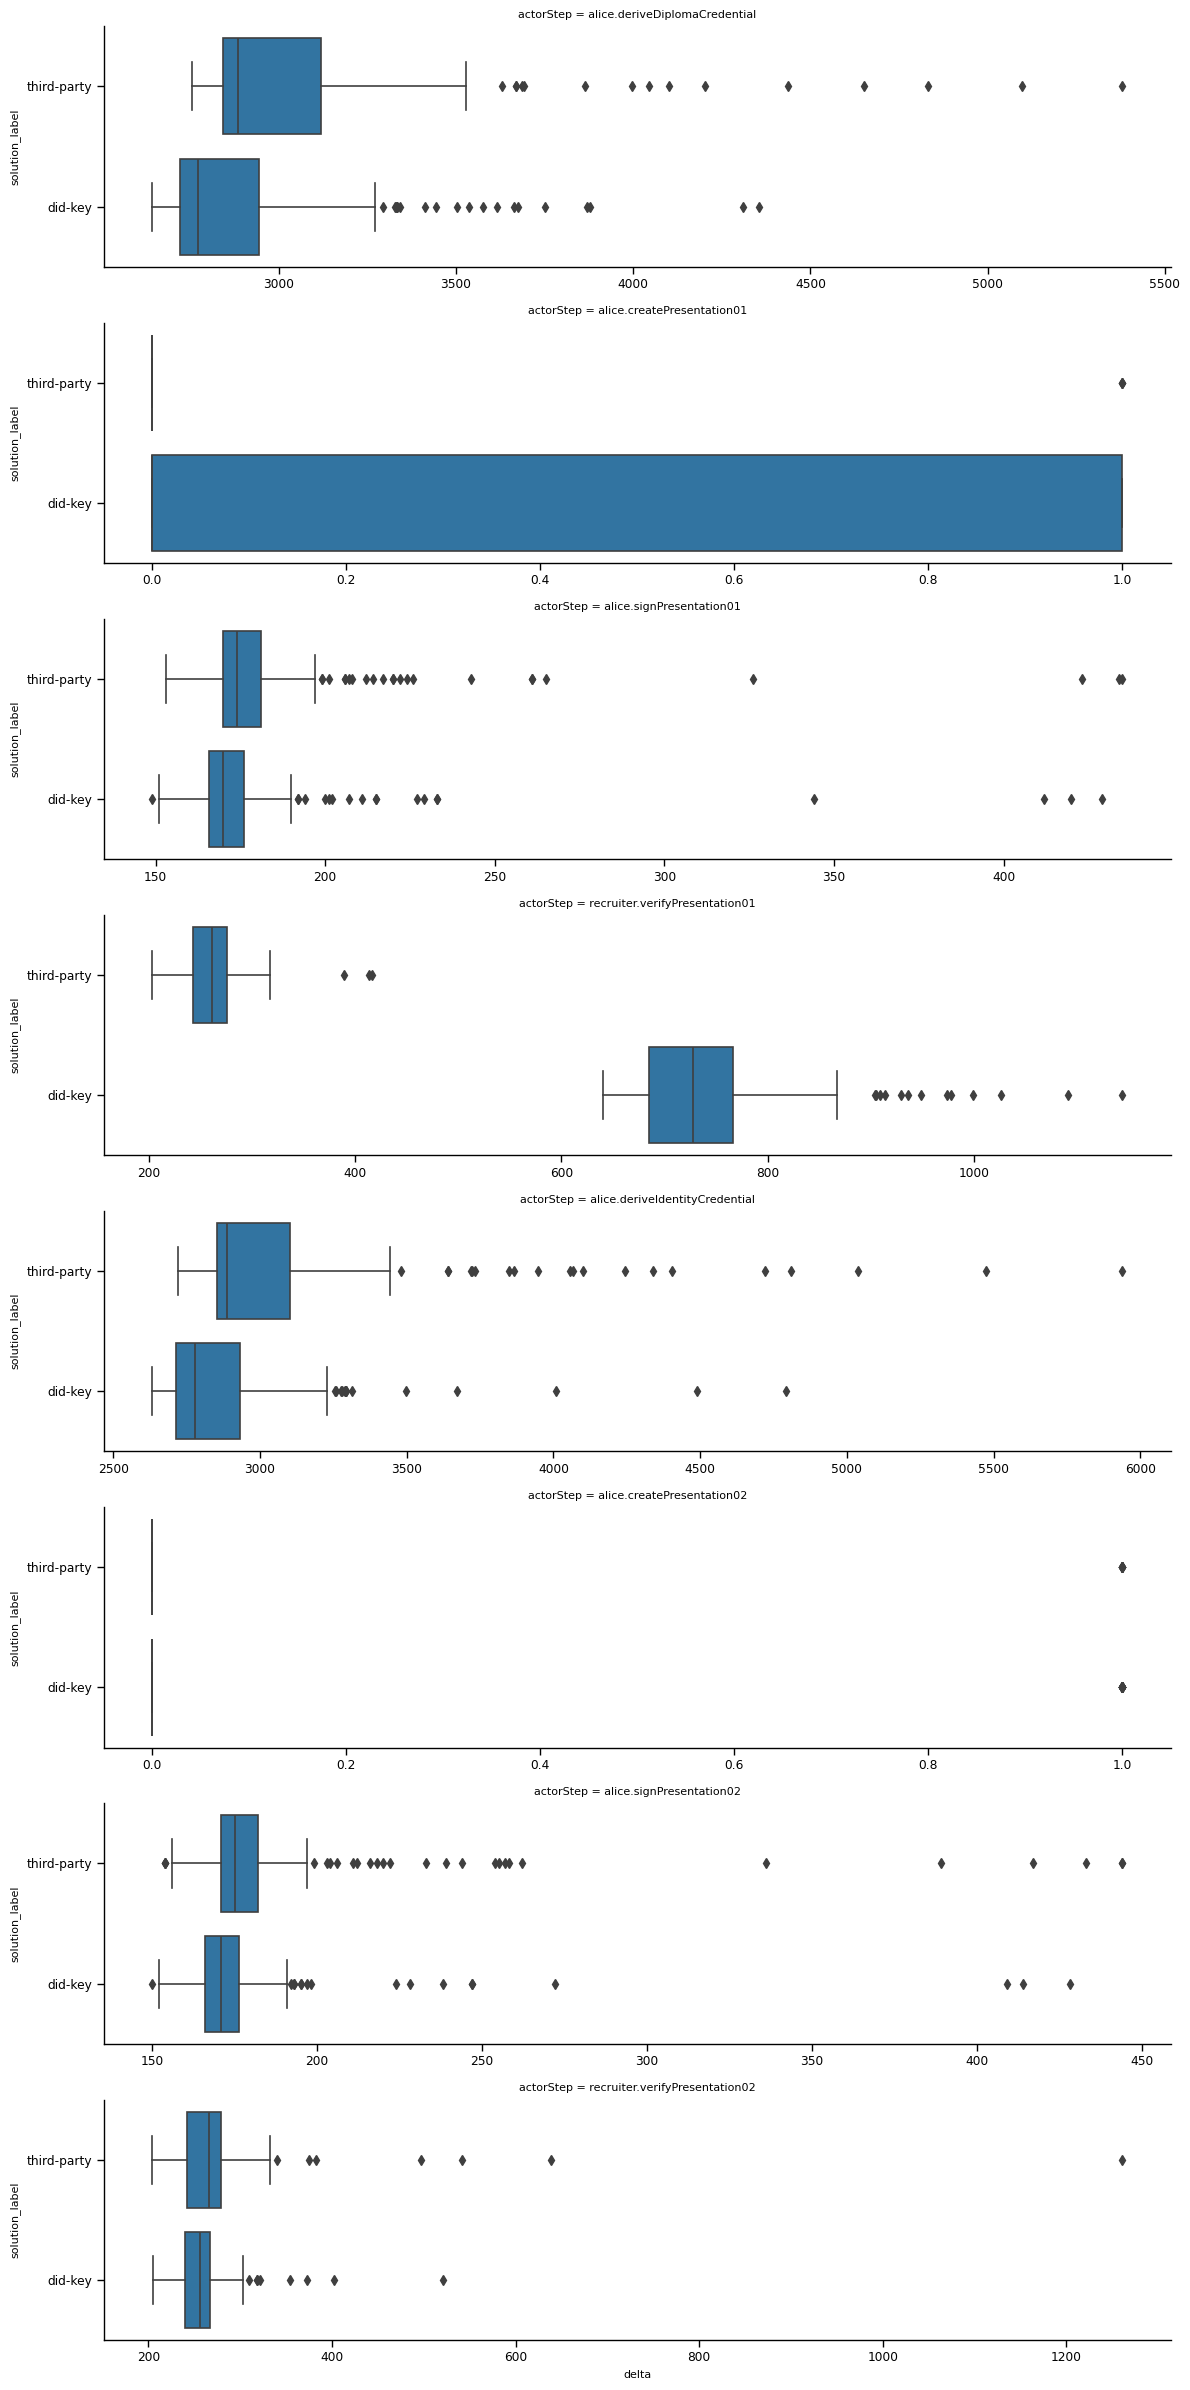

In [24]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x=VAR_X, y='solution_label')
plt.show()

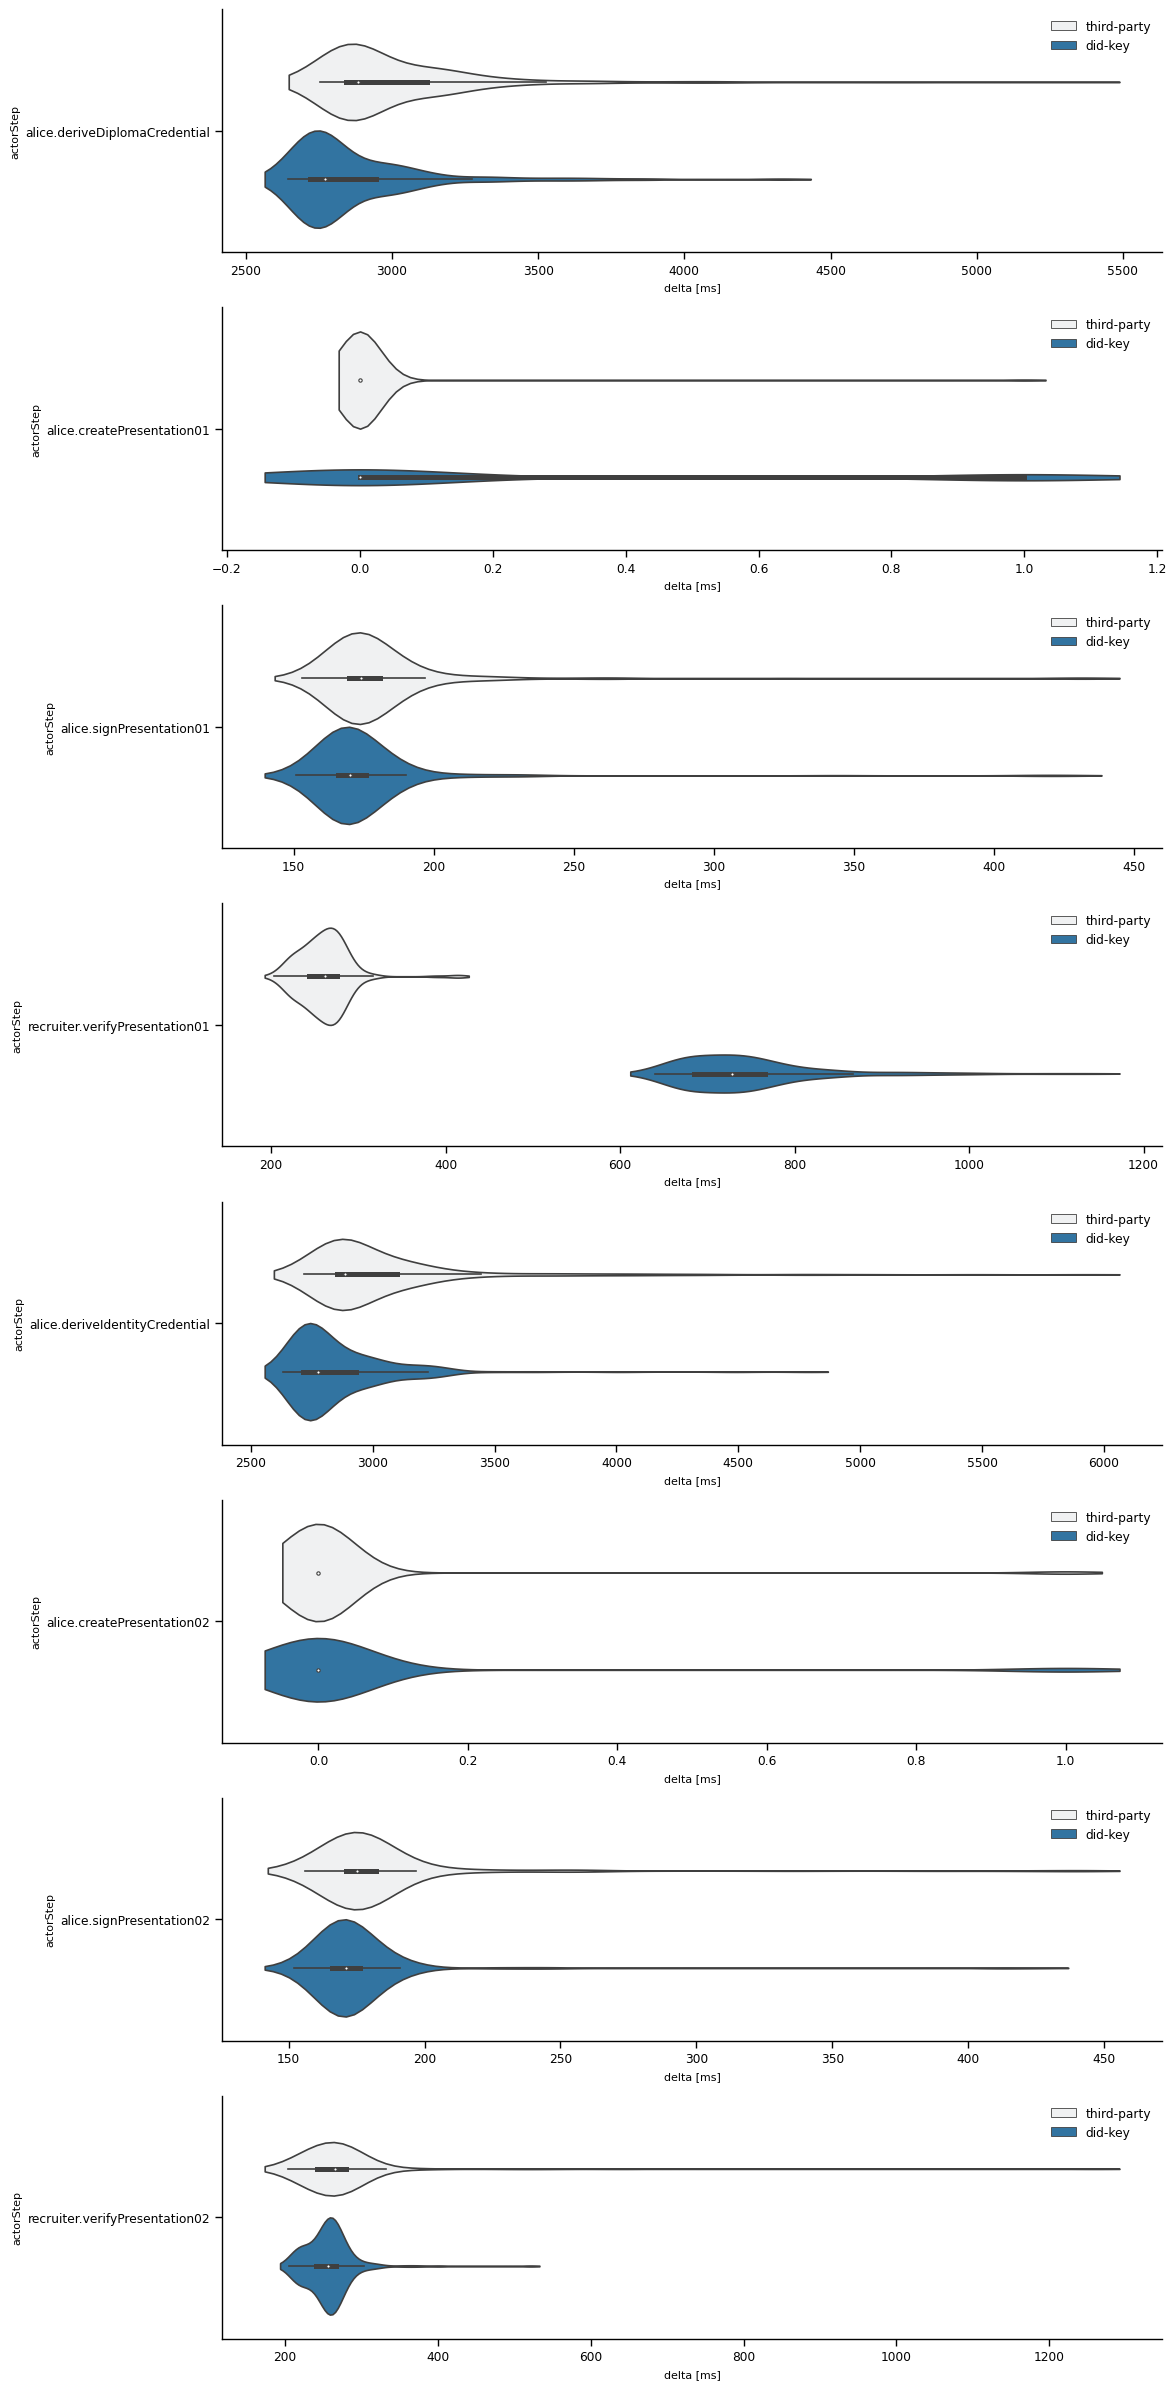

In [25]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='solution_label',
    orient='h',
    showfliers=False,
)

g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [26]:
# name refers to the function/step name
df_tl_agg = df_tl.report.groupby(['actorTag','solution_label','stepName'])[['delta']].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [27]:
df_tl_agg.unstack('solution_label').swaplevel(1,2,axis=1).sort_index(axis=1)

delta                                \
solution_label                      did-key                                 
                                      count       kurt   max         mean   
actorTag   stepName                                                         
alice      createPresentation01         300  -0.999704     1     0.276667   
           createPresentation02         300  14.059506     1     0.053333   
           deriveDiplomaCredential      300  10.788216  4354  2864.330000   
           deriveIdentityCredential     300  24.046031  4792  2854.310000   
           signPresentation01           300  52.624524   429   174.986667   
           signPresentation02           300  57.769878   428   175.450000   
government createIdentityCredential     195  28.282359     1     0.030769   
           signIdentityCredential       195   9.034589  1034   636.364103   
recruiter  verifyPresentation01         195   5.080210  1144   743.630769   
           verifyPresentation02         195  21.401526   521   256.569231   
university createDiplomaCredential      195  94.958388     1     0.010256   
           signDiplomaCredential        195  20.548264  1305   629.758974   

                                                                         \
solution_label                                                            
                                     median   min      skew         std   
actorTag   stepName                                                       
alice      createPresentation01         0.0     0  1.003496    0.448098   
           createPresentation02         0.0     0  3.995725    0.225073   
           deriveDiplomaCredential   2772.5  2643  2.852694  244.508368   
           deriveIdentityCredential  2776.5  2632  3.895985  235.102953   
           signPresentation01         170.0   149  6.782898   29.159574   
           signPresentation02         171.0   150  7.050156   27.676962   
government createIdentityCredential     0.0     0  5.476529    0.173136   
           signIdentityCredential     612.0   576  3.034423   80.935801   
recruiter  verifyPresentation01       728.0   640  1.919480   81.452010   
           verifyPresentation02       256.0   205  3.210807   33.491791   
university createDiplomaCredential      0.0     0  9.797168    0.101013   
           signDiplomaCredential      605.0   563  3.954382   88.411575   

                                                                   \
solution_label                      third-party                     
                                          count        kurt   max   
actorTag   stepName                                                 
alice      createPresentation01             300   96.633088     1   
           createPresentation02             300   38.540315     1   
           deriveDiplomaCredential          300   17.730455  5380   
           deriveIdentityCredential         300   20.241611  5939   
           signPresentation01               300   45.993296   435   
           signPresentation02               300   32.600353   444   
government createIdentityCredential         184   57.944998     1   
           signIdentityCredential           184   14.780704  1405   
recruiter  verifyPresentation01             184    8.175628   416   
           verifyPresentation02             184   91.972981  1261   
university createDiplomaCredential          184  184.000000     1   
           signDiplomaCredential            184   17.063260  1344   

                                                                           \
solution_label                                                              
                                            mean  median   min       skew   
actorTag   stepName                                                         
alice      createPresentation01         0.010000     0.0     0   9.898934   
           createPresentation02         0.023333     0.0     0   6.346922   
           deriveDiplomaCredential   

Compact overview of the each group's mean & median aggregates for the `delta`-variable.

In [28]:
df_tl_agg.unstack('solution_label').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

mean              median            
                                       delta               delta            
solution_label                       did-key third-party did-key third-party
actorTag   stepName                                                         
alice      createPresentation01         0.28        0.01     0.0         0.0
           createPresentation02         0.05        0.02     0.0         0.0
           deriveDiplomaCredential   2864.33     3017.16  2772.5      2885.5
           deriveIdentityCredential  2854.31     3029.30  2776.5      2887.5
           signPresentation01         174.99      180.21   170.0       174.0
           signPresentation02         175.45      182.82   171.0       175.0
government createIdentityCredential     0.03        0.02     0.0         0.0
           signIdentityCredential     636.36      670.70   612.0       635.0
recruiter  verifyPresentation01       743.63      260.53   728.0       261.5
           verifyPresentation02       256.57      271.68   256.0       265.5
university createDiplomaCredential      0.01        0.01     0.0         0.0
           signDiplomaCredential      629.76      659.20   605.0       626.0

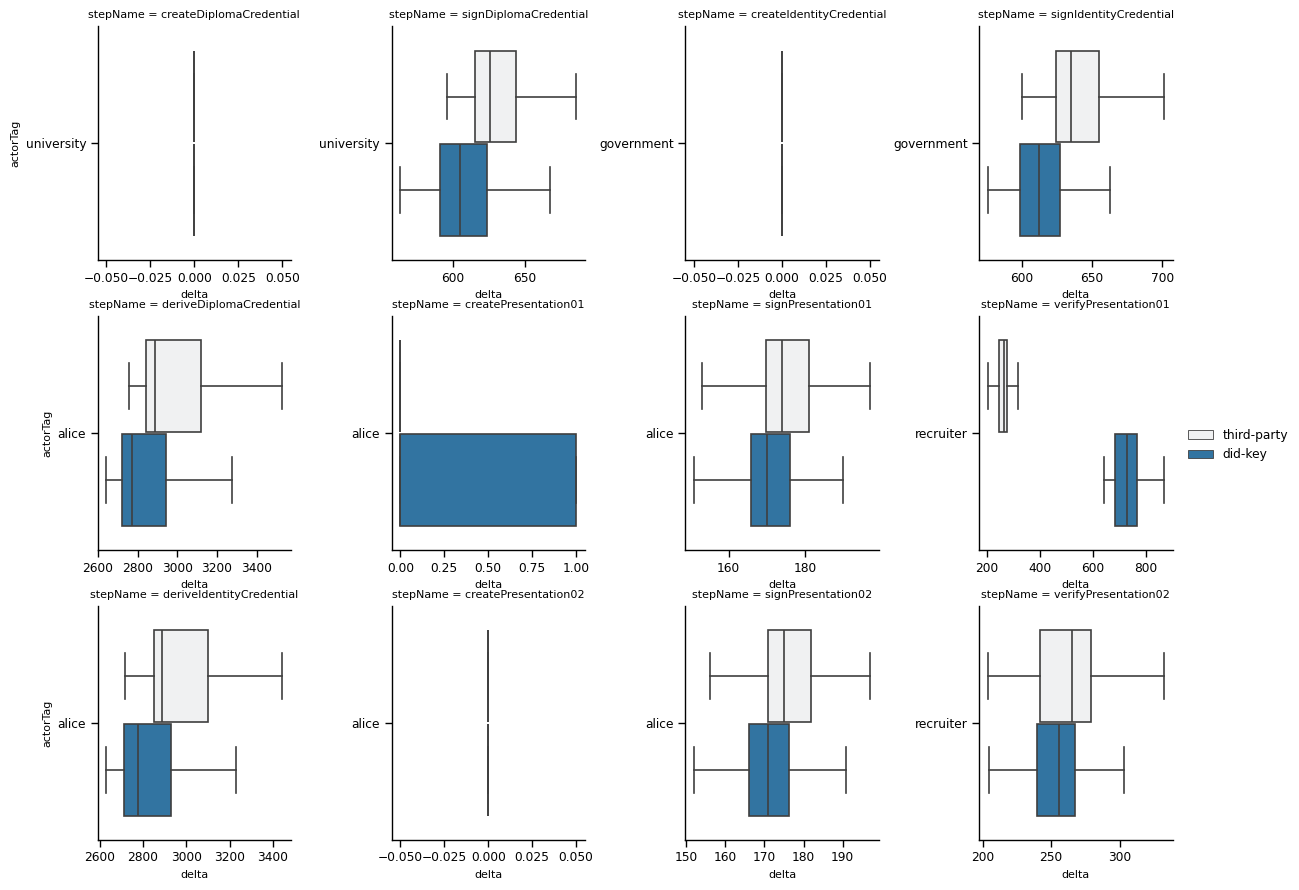

In [29]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='solution_label',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{}'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

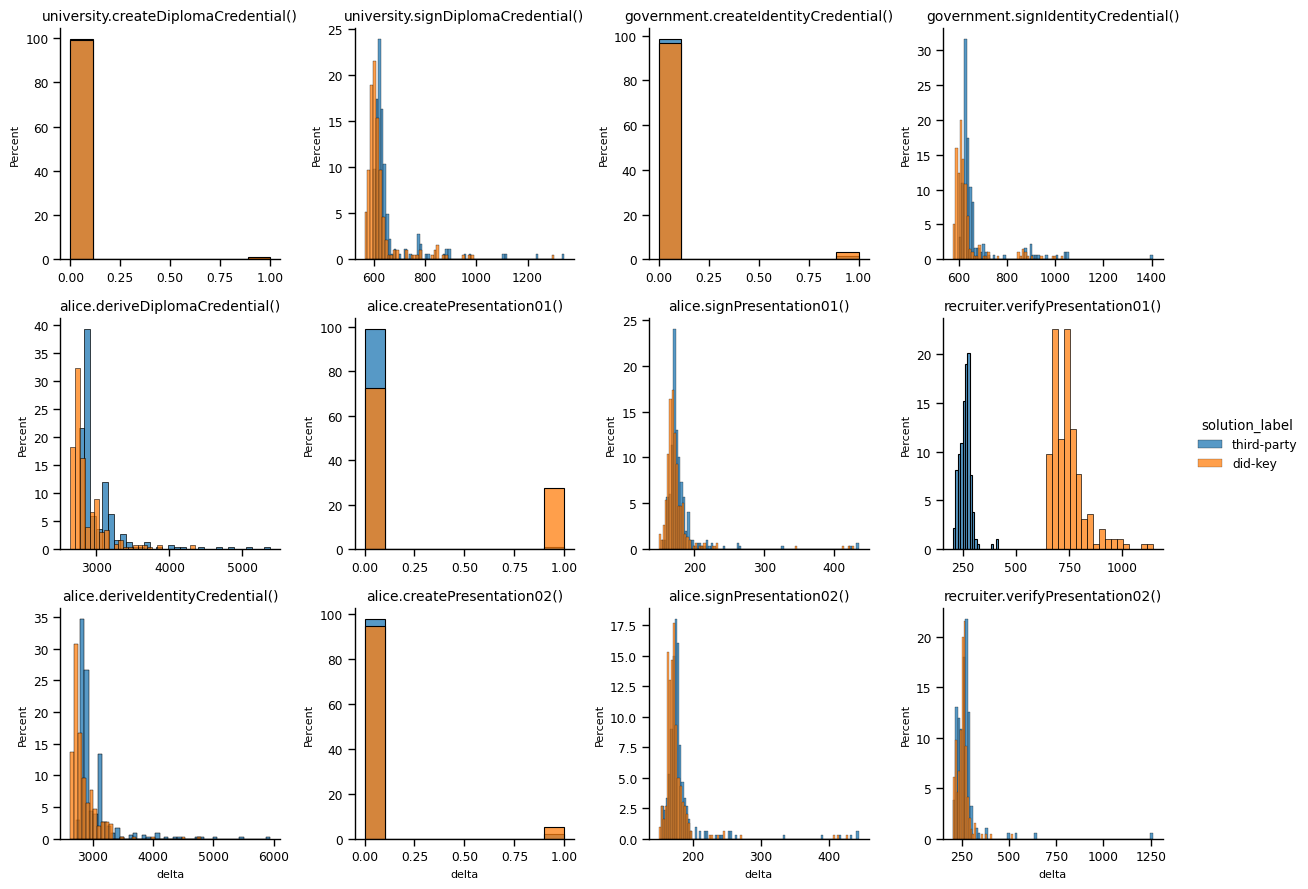

In [36]:
kwargs_fg = dict(col = 'stepName',
                 hue='solution_label',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x=VAR_X,
    stat='percent',
    element='bars',
    log_scale=False
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()


plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'),bbox_inches='tight')
plt.show()

In [37]:
df_tl.report.groupby(['phase','actorTag','solution_label','actorStep'])[['delta']].agg(['mean']).unstack('solution_label')

delta  \
                                                                      mean   
solution_label                                                     did-key   
phase          actorTag   actorStep                                          
phase-1        alice      alice.createPresentation01              0.276667   
                          alice.deriveDiplomaCredential        2864.330000   
                          alice.signPresentation01              174.986667   
               recruiter  recruiter.verifyPresentation01        743.630769   
phase-2        alice      alice.createPresentation02              0.053333   
                          alice.deriveIdentityCredential       2854.310000   
                          alice.signPresentation02              175.450000   
               recruiter  recruiter.verifyPresentation02        256.569231   
pre-evaluation government government.createIdentityCredential     0.030769   
                          government.signIdentityCredential     636.364103   
               university university.createDiplomaCredential      0.010256   
                          university.signDiplomaCredential      629.758974   

                                                                            
                                                                            
solution_label                                                 third-party  
phase          actorTag   actorStep                                         
phase-1        alice      alice.createPresentation01              0.010000  
                          alice.deriveDiplomaCredential        3017.163333  
                          alice.signPresentation01              180.210000  
               recruiter  recruiter.verifyPresentation01        260.532609  
phase-2        alice      alice.createPresentation02              0.023333  
                          alice.deriveIdentityCredential       3029.303333  
                          alice.signPresentation02              182.820000  
               recruiter  recruiter.verifyPresentation02        271.679348  
pre-evaluation government government.createIdentityCredential     0.016304  
                          government.signIdentityCredential     670.701087  
               university university.createDiplomaCredential      0.005435  
                          university.signDiplomaCredential      659.201087

In [38]:
# TODO: REFACTOR
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

In [40]:
raise Exception('BELOW NEEDS REVISION. BREAKING CHANGES SINCE PROFILER-V2')

Exception: BELOW NEEDS REVISION. BREAKING CHANGES SINCE PROFILER-V2

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [315]:
p_thresh = .05

In [316]:
steps = df_tl.report.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [324]:
steps= [

 'deriveDiplomaCredential',
    'createPresentation01', 'signPresentation01',
 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02'
 'signPresentation02', 'verifyPresentation02'
]

> Breaking since profiler-v2 update

In [325]:
grpr_className = df_tl.report.groupby('solution_label')
assert grpr_className.ngroups == 2 # sanity check
A,B = grpr_className

In [326]:
df_a

,actorStep,actorTag,className,delta,end,start,stepName,solution_label,phase,delta_log1p
300,university.createDiplomaCredential,university,SolidVCActor,0,1701853957896,1701853957896,createDiplomaCredential,did-key,pre-evaluation,0.000000
302,university.createDiplomaCredential,university,SolidVCActor,0,1701854914817,1701854914817,createDiplomaCredential,did-key,pre-evaluation,0.000000
304,university.createDiplomaCredential,university,SolidVCActor,0,1701853325034,1701853325034,createDiplomaCredential,did-key,pre-evaluation,0.000000
305,university.createDiplomaCredential,university,SolidVCActor,0,1701854361009,1701854361009,createDiplomaCredential,did-key,pre-evaluation,0.000000
306,university.createDiplomaCredential,university,SolidVCActor,0,1701854009410,1701854009410,createDiplomaCredential,did-key,pre-evaluation,0.000000
...,...,...,...,...,...,...,...,...,...,...
9493,recruiter.verifyPresentation02,recruiter,SolidVCActor,284,1701822304310,1701822304026,verifyPresentation02,did-key,phase-2,5.652489
9494,recruiter.verifyPresentation02,recruiter,SolidVCActor,219,1701822583887,1701822583668,verifyPresentation02,did-key,phase-2,5.393628
9495,recruiter.verifyPresentation02,recruiter,SolidVCActor,237,1701822559216,1701822558979,verifyPresentation02,did-key,phase-2,5.472271
9496,recruiter.verifyPresentation02,recruiter,SolidVCActor,250,1701822000619,1701822000369,verifyPresentation02,did-key,phase-2,5.525453


In [327]:
steps

['deriveDiplomaCredential',
 'createPresentation01',
 'signPresentation01',
 'verifyPresentation01',
 'deriveIdentityCredential',
 'createPresentation02signPresentation02',
 'verifyPresentation02']

In [328]:
_var = VAR_X
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        if np.shape(a) != np.shape(b):
            print(f'Groups for step: {step_name} are different:', np.shape(a), np.shape(b))
        assert np.shape(a) == np.shape(b)

        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference (p<{p_thresh}) in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results.to_csv(os.path.join(DIR_REPORT, 'df_significance-tests.csv'))
df_test_results


    Group A: did-key
    Group B: third-party
    Tested variable: delta

Groups for step: verifyPresentation01 are different: (254,) (248,)


AssertionError: 

In [37]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(list(steps_with_sig_diff))

['createDiplomaCredential', 'createIdentityCredential', 'deriveDiplomaCredential', 'createPresentation01', 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02', 'verifyPresentation02']


In [38]:
df_tl_sig_diff = df_tl.report[df_tl.report.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(25776, 9)

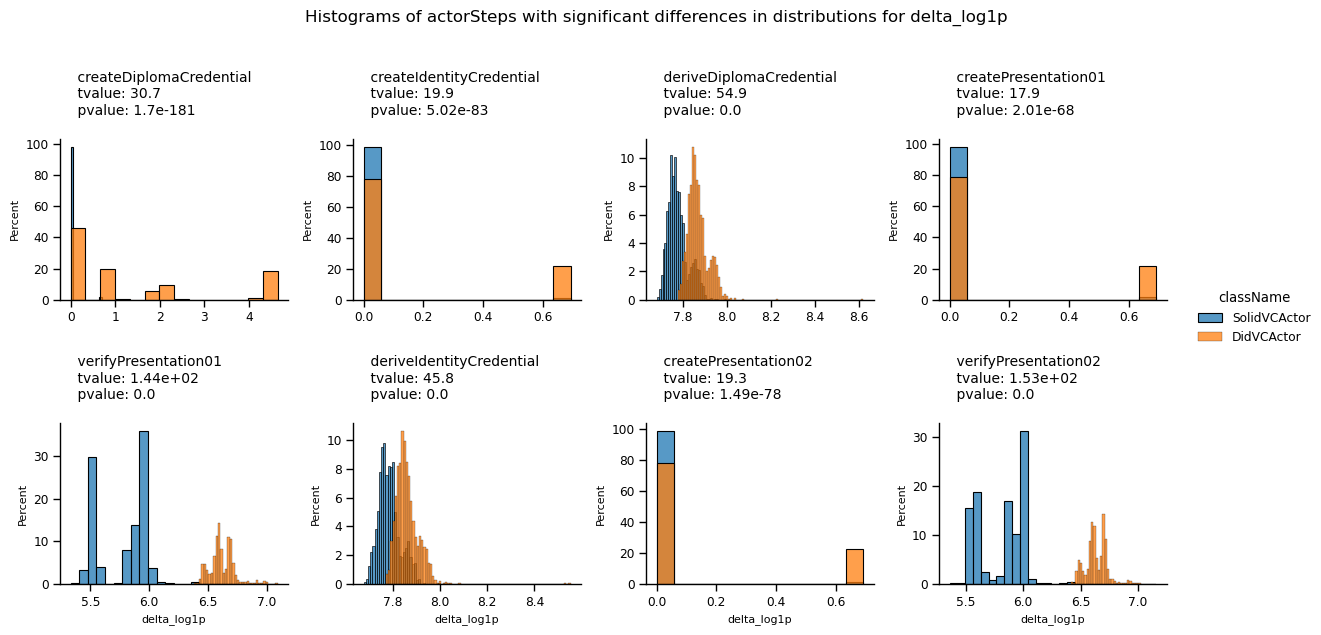

In [39]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False, col_wrap=4)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')
    
g.tight_layout()
suptitle = plt.suptitle(f'Histograms of actorSteps with significant differences in distributions for {VAR_X}',y=1.05)
plt.show()

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [40]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [41]:
_var = 'delta_log1p'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        

colname_effect_size =f'cohend_{k_a}_{k_b}__{_var}'
s_effect_sizes = pd.Series(effect_size_per_step, name=colname_effect_size)

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
def create_explanation(r) -> str:
    es = r[colname_effect_size]
    pos = es > 0
    ec = r.effect_class
    
    return f'The mean of {k_a} is {"greater" if pos else "smaller"} than the mean of {k_b}, with effect size: {es} (which can be classified as {ec}).'
df_effect_sizes['explanation'] = df_effect_sizes.apply(create_explanation, axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))
df_effect_sizes

,cohend_DidVCActor_SolidVCActor__delta_log1p,effect_class,explanation
createDiplomaCredential,1.080773,LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.0807728471248015 (which can be classified as LARGE)."
signDiplomaCredential,-0.023923,VERY_SMALL,"The mean of DidVCActor is smaller than the mean of SolidVCActor, with effect size: -0.023923086355168335 (which can be classified as VERY_SMALL)."
createIdentityCredential,0.700366,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.7003657426658256 (which can be classified as MEDIUM)."
signIdentityCredential,0.015874,VERY_SMALL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.01587384994798249 (which can be classified as VERY_SMALL)."
deriveDiplomaCredential,1.935375,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.9353750560549572 (which can be classified as VERY_LARGE)."
createPresentation01,0.630884,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6308841479017578 (which can be classified as MEDIUM)."
signPresentation01,0.006504,NIHIL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.006504101508290548 (which can be classified as NIHIL)."
verifyPresentation01,5.065694,HUGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 5.065694180002759 (which can be classified as HUGE)."
deriveIdentityCredential,1.612722,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.6127219828890706 (which can be classified as VERY_LARGE)."
createPresentation02,0.679689,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6796890528600683 (which can be classified as MEDIUM)."


/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_5415/1671008354.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)


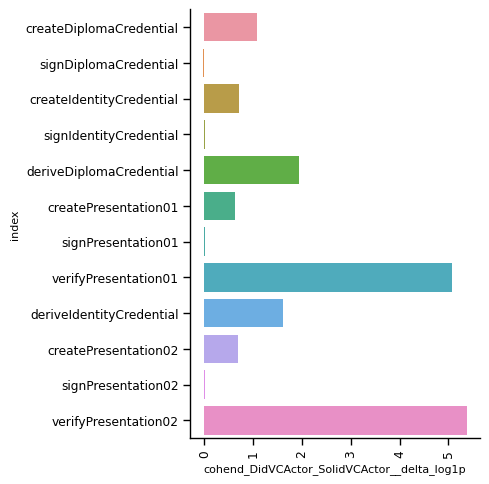

In [42]:
g= sns.catplot(df_effect_sizes.reset_index(),y='index',x=colname_effect_size, kind='bar',orient='h')
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.show()

---
### [WIP] Analyze effects of document loader cache option configurations

In [68]:
def plot_stepname_histograms_per_dlco_group(df: pd.DataFrame, selected_stepName: str):
    # Create grouper based on different document loader cache configurations
    GROUP_COLUMNS_DLCO = df[['dlco']].columns.to_list()
    grpr_dlco = df.groupby(GROUP_COLUMNS_DLCO)
    snsdata = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).report.reset_index().rename({'level_0':'dlco_group'}, axis=1)
    snsdata = snsdata[snsdata.stepName == selected_stepName]
    df_dlco_group_table = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).reset_index().rename({'level_0':'dlco_group'}, axis=1)[['dlco_group','dlco']].drop_duplicates().droplevel(0, axis=1).dropna(how='all',axis=1).rename({'':'DLCO_GROUP'},axis=1).set_index('DLCO_GROUP').T
    df_dlco_group_table_marks = df_dlco_group_table.replace({True: '√', False: 'x'})

    g = sns.FacetGrid(snsdata,row = 'dlco_group',aspect=4,sharex=True, sharey=True, hue='className')
    g.map_dataframe(sns.histplot,x='delta_log1p', stat='percent')
    g.add_legend()

    for g_k, ax_k in g.axes_dict.items():
        g_size = snsdata.groupby('dlco_group').size()[g_k]
        title_center = ax_k.get_title()
        ax_k.set_title(f'{g_k}\n',loc='left')
        ax_k.set_title("\n".join(map(lambda x: '{}: {}'.format(*x), df_dlco_group_table_marks[g_k].to_dict().items())),loc='center', )
        title_right = f'{selected_stepName}\nN: {g_size}'
        ax_k.set_title(title_right,loc='right', fontdict = {'fontsize': 8})

    g.tight_layout()
    
    return g

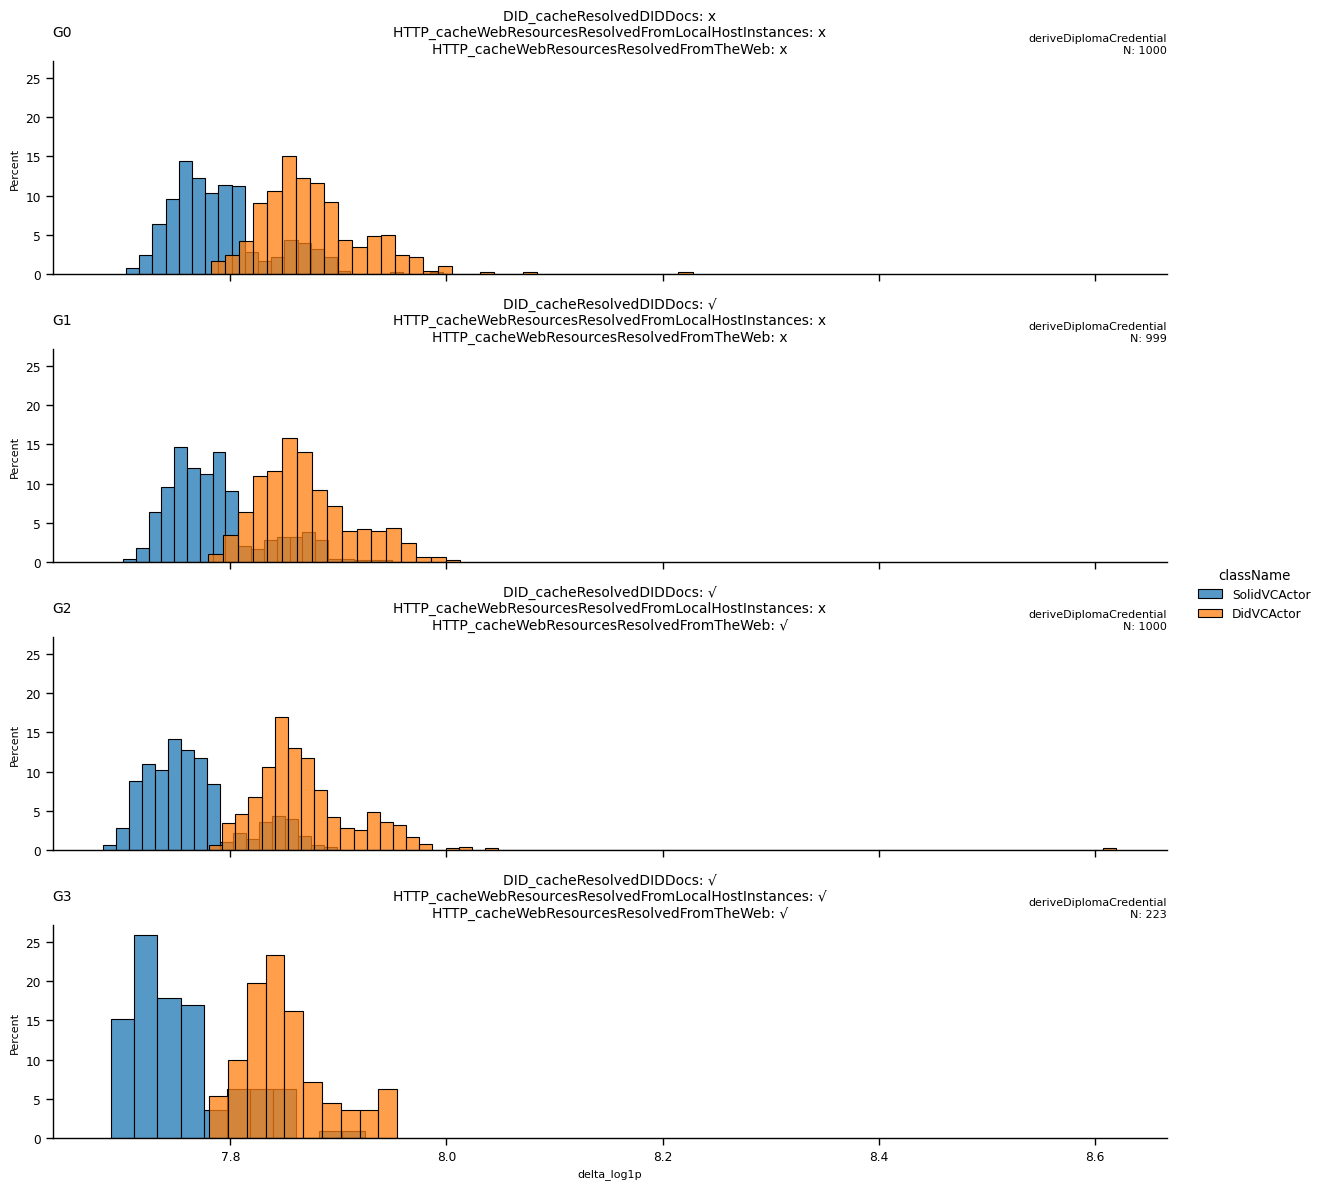

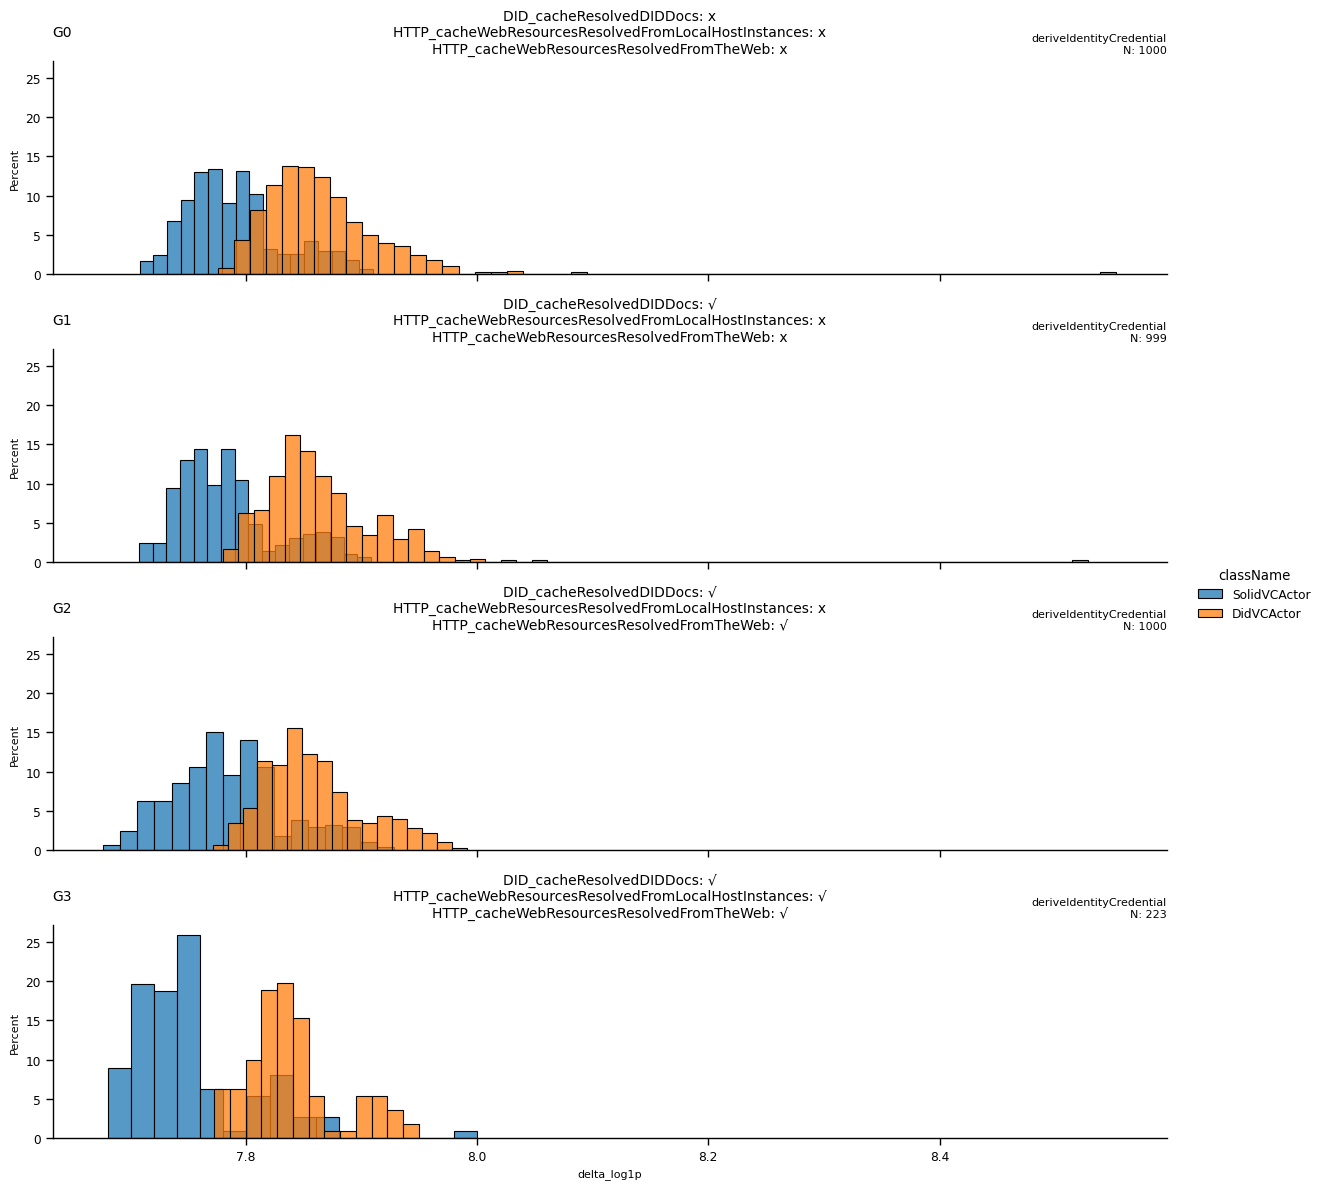

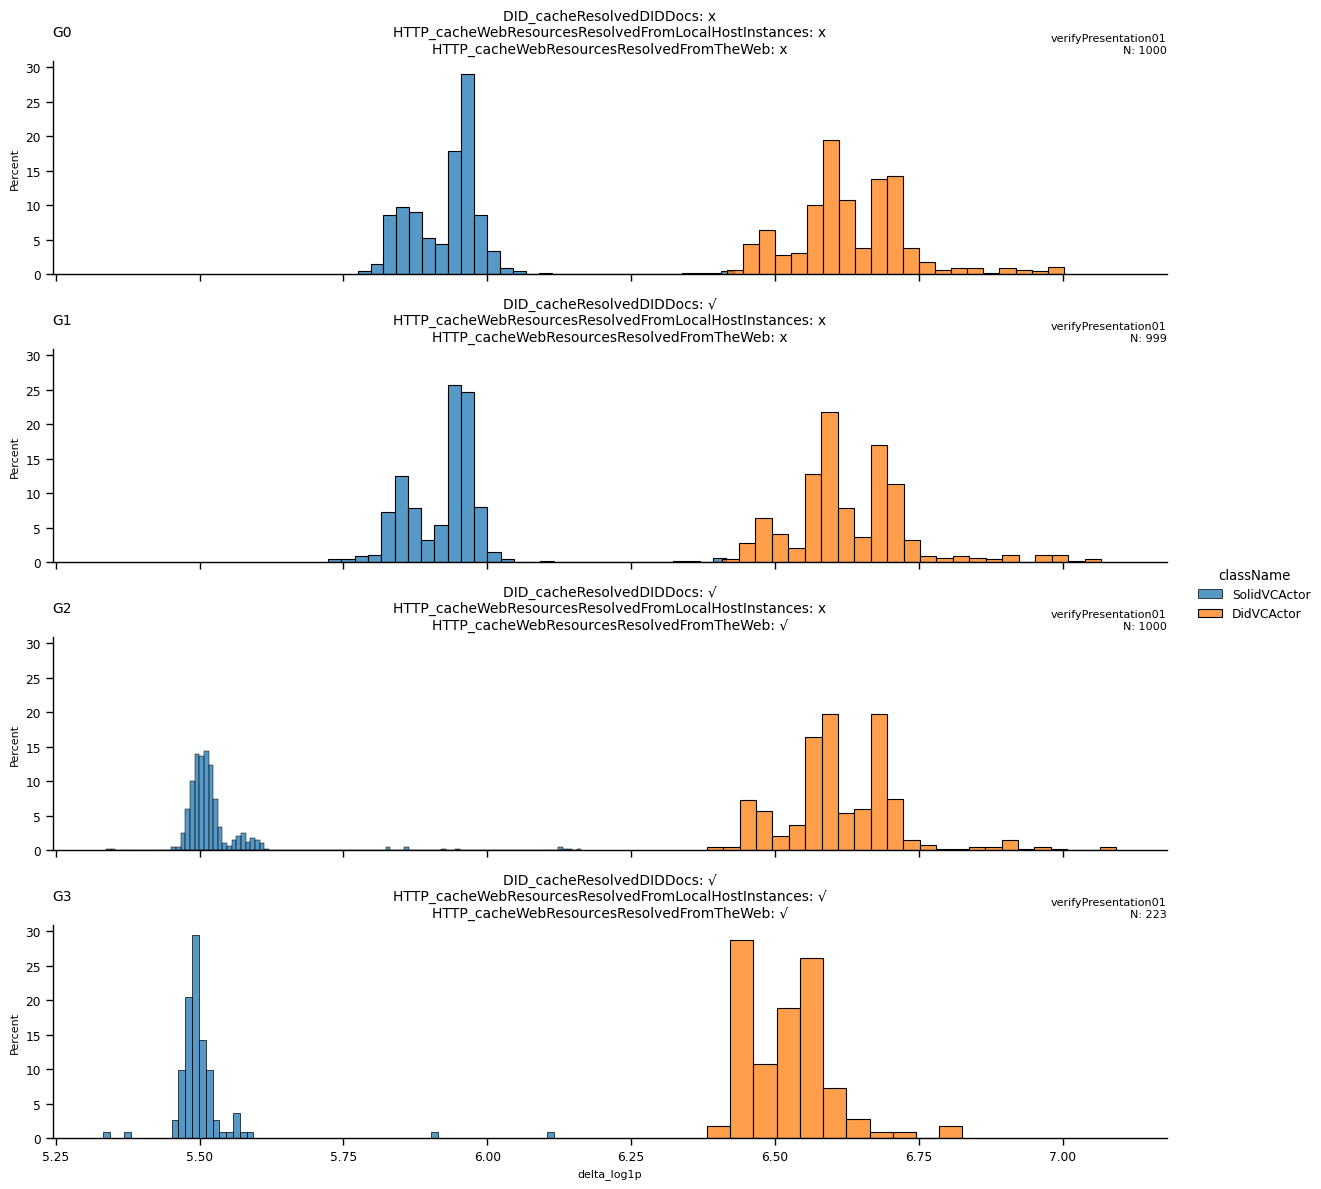

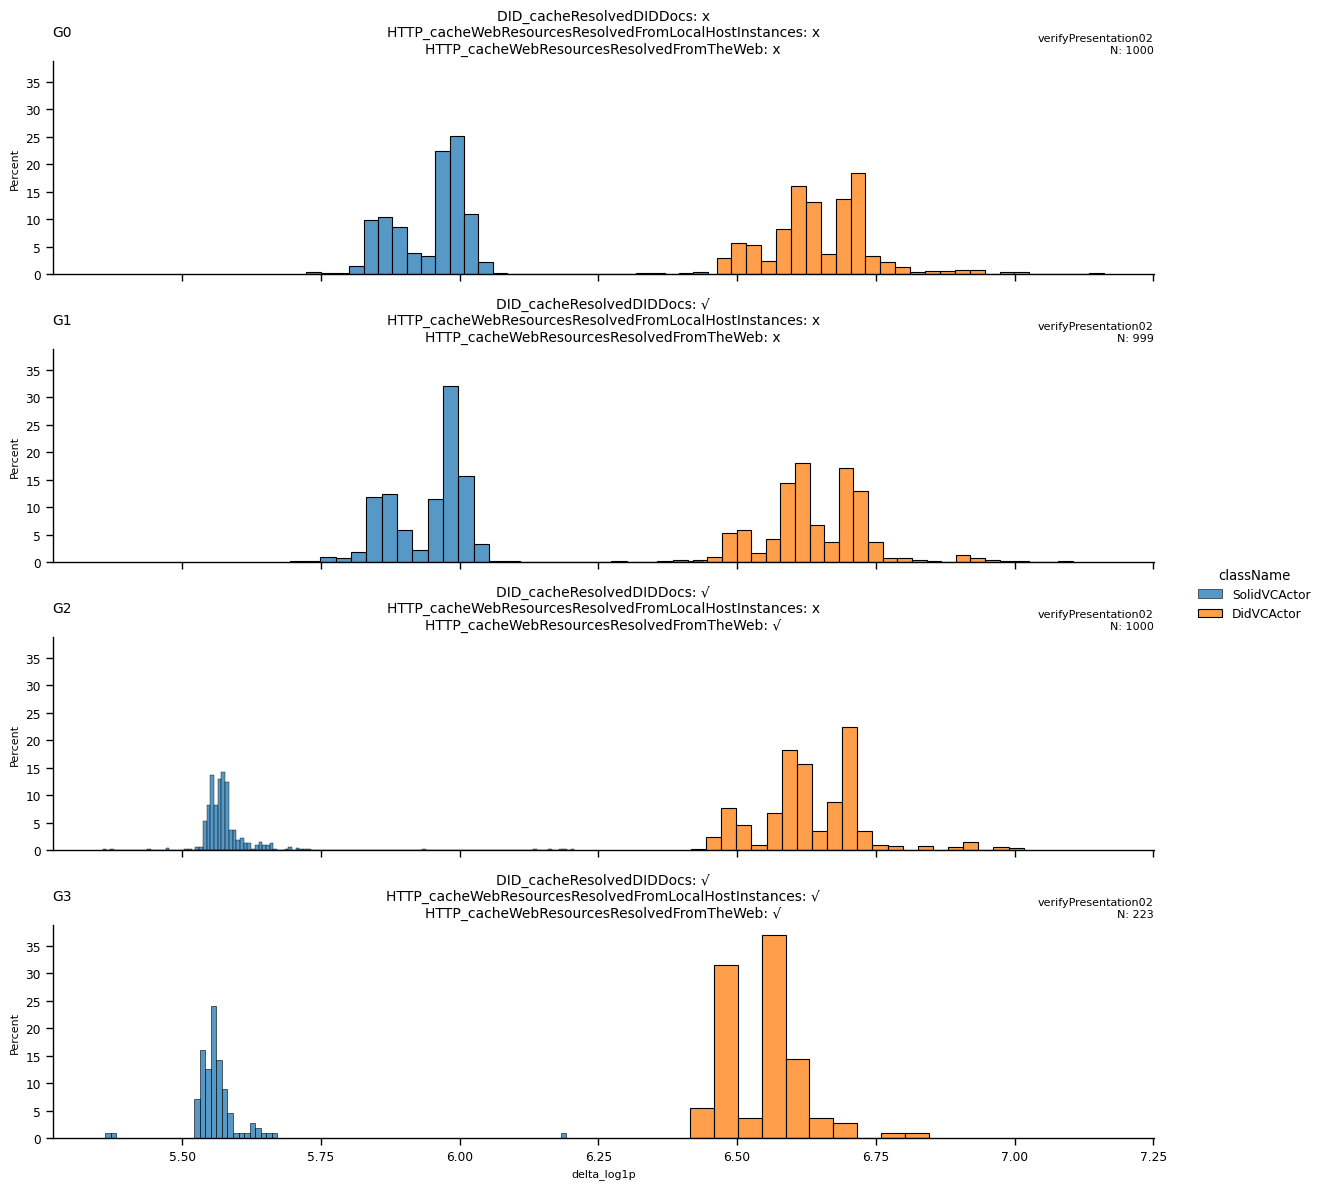

In [74]:
for sn in [ 'deriveDiplomaCredential', 'deriveIdentityCredential', 'verifyPresentation01', 'verifyPresentation02']:    
    g = plot_stepname_histograms_per_dlco_group(df_tl, sn)
    g.savefig(os.path.join(DIR_REPORT, f'histograms-per-dlco-group_{sn}.png'))